<a href="https://colab.research.google.com/github/hasanahaffendy/STQD6234-DataManagement/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark import SparkConf, SparkContext

In [ ]:
# Initialize Spark context and session
conf = SparkConf().setAppName("Iris Classification")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [ ]:
# Load the Iris dataset
iris_data = spark.read.csv("file:///home/maria_dev/hasanah/iris.csv", header=True, inferSchema=True)

In [ ]:
# Rename the columns to match feature names
iris_data = iris_data.withColumnRenamed("Sepal.Length", "sepalLength") \
                     .withColumnRenamed("Sepal.Width", "sepalWidth") \
                     .withColumnRenamed("Petal.Length", "petalLength") \
                     .withColumnRenamed("Petal.Width", "petalWidth") \
                     .withColumnRenamed("Species", "label")


In [ ]:
# Index labels (convert string labels to numeric)
indexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(iris_data)
iris_data = indexer.transform(iris_data)

In [ ]:
# Verify the label indexing
label_to_index = {row['label']: row['indexedLabel'] for row in iris_data.select("label", "indexedLabel").distinct().collect()}
print("Label to Index Mapping:", label_to_index)

In [ ]:
# Select the relevant columns
iris_data = iris_data.select('features', 'indexedLabel')

In [ ]:
# Split the data
train_data, test_data = iris_data.randomSplit([0.7, 0.3], seed=42)

In [ ]:
# Initialize the classifier
dt = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='features')

In [ ]:
# Create a parameter grid for cross-validation
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 4, 6])
             .addGrid(dt.maxBins, [20, 30, 40])
             .build())

In [ ]:
# Create CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(labelCol='indexedLabel', metricName='accuracy'),
                    numFolds=3)

In [ ]:
# Initialize the classifier
dt = DecisionTreeClassifier(labelCol='label', featuresCol='features')

In [ ]:
# Create a parameter grid for cross-validation
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 4, 6])
             .addGrid(dt.maxBins, [20, 30, 40])
             .build())


In [ ]:
# Fit the model
cvModel = cv.fit(train_data)

In [ ]:
# Make predictions on the test data
predictions = cvModel.transform(test_data)

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")

In [ ]:
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

In [ ]:
print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1-Score: {}".format(f1))

In [ ]:
# Show predictions
predictions.select("features", "indexedLabel", "prediction").show(10)

In [ ]:
# Compare predicted and actual labels, and convert to Pandas DataFrame
try:
    predicted_vs_actual = predictions.select("prediction", "indexedLabel").toPandas()
    # Print a few comparisons
    print(predicted_vs_actual.head(10))
except Exception as e:
    print("Error during conversion to Pandas DataFrame:", e)
    # Print the number of rows in the predictions DataFrame to help diagnose
    print("Number of rows in predictions DataFrame:", predictions.count())

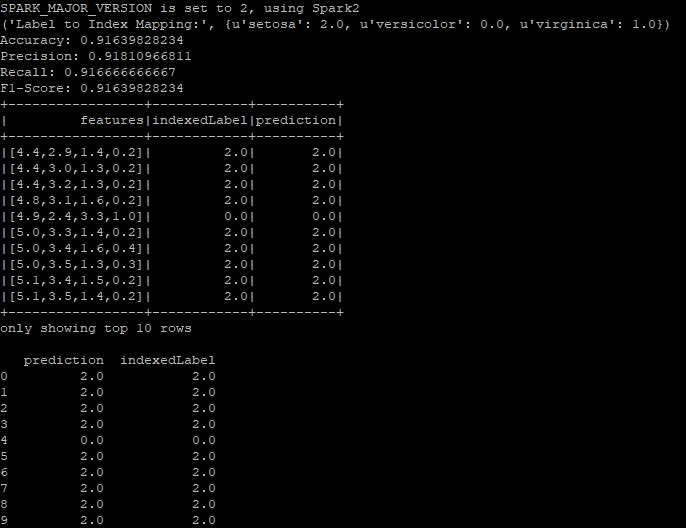

In [1]:
from IPython.display import Image

# Specify the path to your image file
image_path = '/content/drive/MyDrive/DataScience/output.jpg'

# Display the image
Image(filename=image_path)